### Data Exploration

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
train_ann_df = pd.read_csv('/content/drive/MyDrive/Released_Data_NNDL_2025/train_data.csv')
super_map_df = pd.read_csv('/content/drive/MyDrive/Released_Data_NNDL_2025/superclass_mapping.csv')
sub_map_df = pd.read_csv('/content/drive/MyDrive/Released_Data_NNDL_2025/subclass_mapping.csv')

In [30]:
# mapping
superclass_map = dict(zip(super_map_df['index'], super_map_df['class']))
subclass_map = dict(zip(sub_map_df['index'], sub_map_df['class']))

train_ann_df['superclass_name'] = train_ann_df['superclass_index'].map(superclass_map)
train_ann_df['subclass_name'] = train_ann_df['subclass_index'].map(subclass_map)

In [31]:
print("Super-class distribution:")
print(train_ann_df['superclass_name'].value_counts())

Super-class distribution:
superclass_name
reptile    2354
dog        2084
bird       1850
Name: count, dtype: int64


<ipython-input-32-bf36ddf742d0>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


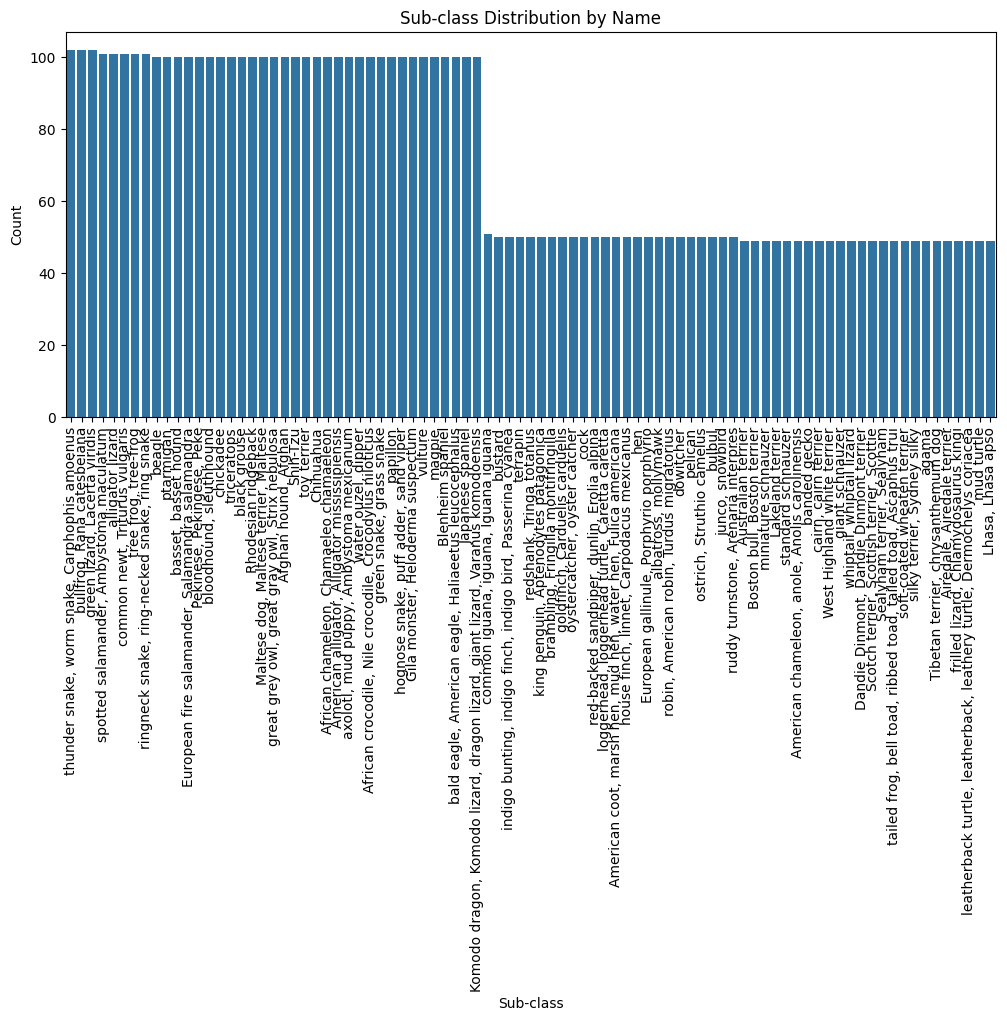

In [32]:
plt.figure(figsize=(12, 5))
sns.countplot(x='subclass_name', data=train_ann_df, order=train_ann_df['subclass_name'].value_counts().index)
plt.title("Sub-class Distribution by Name")
plt.xlabel("Sub-class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [33]:
grouped = train_ann_df[['superclass_name', 'subclass_name']].drop_duplicates().groupby('superclass_name')['subclass_name'].apply(list)

for superclass, subclasses in grouped.items():
    print(f"Superclass '{superclass}' has the following {len(subclasses)} subclasses:")
    for subclass in subclasses:
        print(f"  - {subclass}")
    print()

Superclass 'bird' has the following 29 subclasses:
  - oystercatcher, oyster catcher
  - great grey owl, great gray owl, Strix nebulosa
  - redshank, Tringa totanus
  - king penguin, Aptenodytes patagonica
  - brambling, Fringilla montifringilla
  - goldfinch, Carduelis carduelis
  - indigo bunting, indigo finch, indigo bird, Passerina cyanea
  - cock
  - ptarmigan
  - red-backed sandpiper, dunlin, Erolia alpina
  - black grouse
  - vulture
  - magpie
  - house finch, linnet, Carpodacus mexicanus
  - chickadee
  - bald eagle, American eagle, Haliaeetus leucocephalus
  - hen
  - American coot, marsh hen, mud hen, water hen, Fulica americana
  - European gallinule, Porphyrio porphyrio
  - water ouzel, dipper
  - junco, snowbird
  - ruddy turnstone, Arenaria interpres
  - ostrich, Struthio camelus
  - bulbul
  - albatross, mollymawk
  - bustard
  - pelican
  - dowitcher
  - robin, American robin, Turdus migratorius

Superclass 'dog' has the following 29 subclasses:
  - Maltese dog, Maltes

### Data Preprosessing

In [34]:
from PIL import Image
from PIL import UnidentifiedImageError
import os
import numpy as np
import csv
from collections import defaultdict
import shutil

In [35]:
novel_dirs = {
    "dog": "/content/drive/MyDrive/Novel_dataset/dog_novel",
    "bird": "/content/drive/MyDrive/Novel_dataset/bird_novel",
    "reptile": "/content/drive/MyDrive/Novel_dataset/reptile_novel",
    "super": "/content/drive/MyDrive/Novel_dataset/super_novel"
}

In [36]:
novel_train_img_dir = '/content/drive/MyDrive/Released_Data_NNDL_2025/train_images_with_novel'
train_img_dir = '/content/drive/MyDrive/Released_Data_NNDL_2025/train_images'

if os.path.exists(novel_train_img_dir):
    shutil.rmtree(novel_train_img_dir)
os.makedirs(novel_train_img_dir)

In [37]:
new_image_start_id = 6288
new_subclass_index = 87
new_superclass_index = 3
new_records = []

In [38]:
for super_cls, root_dir in novel_dirs.items():
    for subclass_name in os.listdir(root_dir):
        subclass_dir = os.path.join(root_dir, subclass_name)
        if not os.path.isdir(subclass_dir):
            continue

        for filename in os.listdir(subclass_dir):
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            source_img_path = os.path.join(subclass_dir, filename)
            target_img_path = os.path.join(novel_train_img_dir, f"{new_image_start_id}.jpg")

            try:
                img = Image.open(source_img_path).convert("RGB")
                img = img.resize((64, 64), Image.BILINEAR)
                img.save(target_img_path)
            except UnidentifiedImageError:
                print(f"Skipped unreadable image: {source_img_path}")
                continue
            except Exception as e:
                print(f"Other error occurred while processing {source_img_path}: {e}")
                continue

            csv_filename = f"{new_image_start_id}.jpg"
            subclass_idx = new_subclass_index

            if super_cls == "super":
                superclass_idx = new_superclass_index
            else:
                superclass_idx = int(super_map_df[super_map_df["class"] == super_cls]["index"].values[0])

            new_records.append({
                "image": csv_filename,
                "superclass_index": superclass_idx,
                "subclass_index": subclass_idx
            })

            new_image_start_id += 1

In [39]:
new_df = pd.DataFrame(new_records)
original_df = pd.read_csv('/content/drive/MyDrive/Released_Data_NNDL_2025/train_data.csv')
updated_df = pd.concat([original_df, new_df], ignore_index=True)
output_csv_path = "/content/drive/MyDrive/Released_Data_NNDL_2025/train_data_novel.csv"
updated_df.to_csv(output_csv_path, index=False)